# Benchmark: Native PyTorch DL vs. NVTabular DL on Rossmann Sales Dataset

## HPO for NVTabular DL

NVTabular data loader for PyTorch showed 10x-20x speedup in comparison to the native PyTorch data loader. This notebook addresses the question, **does the NVTabular data loader convergeces to the same performance as the native PyTorch data loader and in which umber of epochs?**<br><br>

In this notebook, we analyse the convergence performance on the Rossmann Sales dataset.<br><br>

First, we train the native PyTorch data loader five times for 750 epochs to establish a baseline and get the variance
Second, we train the NVtabular data loader five times for 750 epochs with different configurations:
- part_size: ['10MB', '50MB', '100MB', '500MB', '1GB'] 
- shuffle: [False, True]
- dl_part_per_chunk: [1, 2, 4, 8, 16]
<br><br><br>
We ran in total 255 experiments, 5 for native PyTorch data loader and 250 for NVTabular data loader.

We will show in this notebook:<br>
* If both data loaders are trained to **full convergence (750 epochs)**, NVTabular data loader for PyTorch achieves **slightly lower valid RMSPE** than native PyTorch data loader but **requires only 1/8 of the computation time**.
* If both data loaders have the **same compuational budget (time)**, then NVTabular data loader for PyTorch achieves **~24% lower valid RMSPE**.
* The distributions shows that NVTabular data loader convergence similar to native PyToch data loader
* NVTabular data loader achieves **same valid RMSPE amlost independent of the hyperparameters*. **80% of the experiments achieve lower valid RMSPE**
* Analyzing the different configuration for NVTabular data loader shows no trend, **enabling the NVTabular data loader ready-to-use without hyperparameter tuning**.

In [1]:
import pickle
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
files = glob.glob('./output/*.pickle')
len(files)

255

In [3]:
list_df = []

for file in files:
    data = pickle.load(open(file, 'rb'))
    df = pd.DataFrame(data['dl_hist'])
    for key in data.keys():
        if key != 'dl_hist':
            df[key] = data[key]
    list_df.append(df)
    
df = pd.concat(list_df)
df_100 = df[df['epoch']<=100]

In [4]:
metric = 'valid_rmspe'
col_keys = [x for x in df.columns if x not in ['train_loss', 
                                               'train_rmspe', 
                                               'valid_loss', 
                                               'valid_rmspe',
                                               'runtime',
                                               'epoch']]

# Mean of each epoch for 5 experiments
df_me = df.groupby([x for x in df.columns if x not in ['train_loss',
                                                       'train_rmspe', 
                                                       'valid_loss', 
                                                       'valid_rmspe',
                                                       'runtime',
                                                       'no']]).mean().reset_index()

df_100_me = df_100.groupby([x for x in df.columns if x not in ['train_loss',
                                                               'train_rmspe', 
                                                               'valid_loss', 
                                                               'valid_rmspe',
                                                               'runtime',
                                                               'no']]).mean().reset_index()

# Global valid minimum per experiment
df_min = df.groupby([x for x in df.columns if x not in ['train_loss', 
                                                        'train_rmspe', 
                                                        'valid_loss',
                                                        'valid_rmspe',
                                                        'runtime',
                                                        'epoch'
                                                        ]]).min().reset_index()
# Mean of global valid minimum for 5 experiments
df_mm = df_min.groupby([x for x in df.columns if x not in ['train_loss', 
                                                           'train_rmspe', 
                                                           'valid_loss',
                                                           'valid_rmspe',
                                                           'epoch',
                                                           'runtime',
                                                           'no'
                                                          ]]).mean().reset_index()

pd_nvt = df[df['dl_type']=='NVT']
pd_pyt = df[df['dl_type']=='PYT']

pd_nvt_me = df_me[df_me['dl_type']=='NVT']
pd_pyt_me = df_me[df_me['dl_type']=='PYT']

pd_nvt_100_me = df_100_me[df_100_me['dl_type']=='NVT']
pd_pyt_100_me = df_100_me[df_100_me['dl_type']=='PYT']

pd_nvt_mm = df_mm[df_mm['dl_type']=='NVT']
pd_pyt_mm = df_mm[df_mm['dl_type']=='PYT']

### High level comparison

Let's compare the best performing configuration of NVTabular data loader with the native PyTorch data loader. We average the performance per epoch and take the best epoch.

In [5]:
best_pyt = pd_pyt_me.loc[pd_pyt_me['valid_rmspe'].idxmin()]
best_nvt = pd_nvt_me.loc[pd_nvt_me['valid_rmspe'].idxmin()]

Text(0.5, 1.0, 'Speed up')

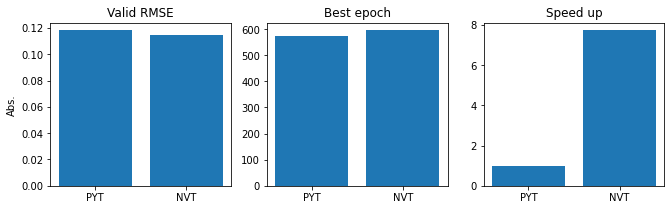

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(11,3))

ax[0].bar(['PYT', 'NVT'], [best_pyt[metric], best_nvt[metric]])
ax[0].set_title('Valid RMSE')
ax[0].set_ylabel('Abs.')
ax[1].bar(['PYT', 'NVT'], [best_pyt['epoch'], best_nvt['epoch']])
ax[1].set_title('Best epoch')
ax[2].bar(['PYT', 'NVT'], [1.0, best_pyt['runtime']/best_nvt['runtime']])
ax[2].set_title('Speed up')

In [7]:
best_pyt['epoch'], best_nvt['epoch']

(573, 595)

The relative performance difference is:

In [8]:
best_nvt[metric]/best_pyt[metric]

0.9734073206585062

Alternatively, we can compare the performance with the same "compute budget". NVTabular data loader is 8x faster, therefore, we can limit the native PyTorch data loader to 100 epoch (~750/8).

In [9]:
best_pyt = pd_pyt_100_me.loc[pd_pyt_100_me['valid_rmspe'].idxmin()]
best_nvt = pd_nvt_me.loc[pd_nvt_me['valid_rmspe'].idxmin()]

Text(0, 0.5, 'Abs.')

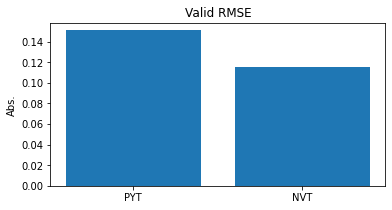

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))

ax.bar(['PYT', 'NVT'], [best_pyt[metric], best_nvt[metric]])
ax.set_title('Valid RMSE')
ax.set_ylabel('Abs.')

The relative performance difference is:

In [11]:
best_nvt[metric]/best_pyt[metric]

0.761904639581761

**Summary:**
We can compare native PyTorch data loader and NVTabular data loader in two ways 1) both are trained until full convergence and compare runtime/epochs 2) given a fixed compute budget, what is the final performance.
<br><br>
1) Full convergence:
* We train both data loader for 750 epochs in total
* NVTabular data loader achieves slightly lower (3%) valid RMSPE than native PyTorch data loader
* NVTabular reaches convergence in slightly more epochs (22 epochs)
* NVTabular requires only 1/8 of the time

2) Fixed compute budget:
* native PyTorch data loader is trained for 100 epochs, NVTabular data loader is trained for 750 epochs
* NVTabular data loader achieves ~24% lower valid RMSPE than native PyTorch data loader

### Detailed level comparison

In [12]:
def plot_basic(pd_pyt, pd_nvt, title=None):
    fig, ax = plt.subplots(1, 2, figsize=(11,3))
    
    y_values_1 = [
        np.squeeze(pd_pyt[col_keys + [metric]].groupby(col_keys).min().values).tolist(),
        np.squeeze(pd_nvt[col_keys + [metric]].groupby(col_keys).min().values).tolist()
    ]
    y_values_2 = [
        np.squeeze(pd_pyt[col_keys + ['epoch', metric]].sort_values(metric).groupby(col_keys).head(1)['epoch'].values).tolist(),
        np.squeeze(pd_nvt[col_keys + ['epoch', metric]].sort_values(metric).groupby(col_keys).head(1)['epoch'].values).tolist()
    ]

    ax[0].boxplot(y_values_1)
    ax[0].set_xticklabels(['PYT', 'NVT'])
    ax[0].set_title(title)
    ax[0].set_ylabel('Best valid score')
    
    ax[1].boxplot(y_values_2)
    ax[1].set_xticklabels(['PYT', 'NVT'])
    ax[1].set_ylabel('Best Epochs')

Overall, NVTabular data loader has a lower median of validation score and the median of best epoch is lower, as well. However, NVTabular data loader has a higher variance, may due to more experiments.

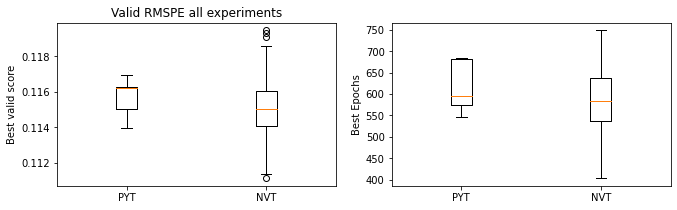

In [13]:
plot_basic(pd_pyt, pd_nvt, 'Valid RMSPE all experiments')

Next, we look at the mean performance per epoch to see the "convergence speed". For native PyTorch data loader, the mean results in a single data point. For best valid score, we see that the majority of experiments have a lower RMSPE than the native PyTorch data loader.

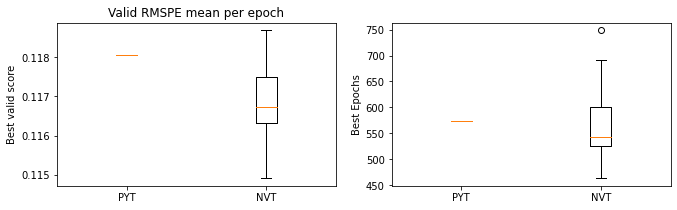

In [14]:
plot_basic(pd_pyt_me, pd_nvt_me, 'Valid RMSPE mean per epoch')

Finally, we take first the minimum of each experiment and average the minimums. Again, we can observe that the NVTabular data loader have a lower RMSPE. The epoch plot is not valid in that case.

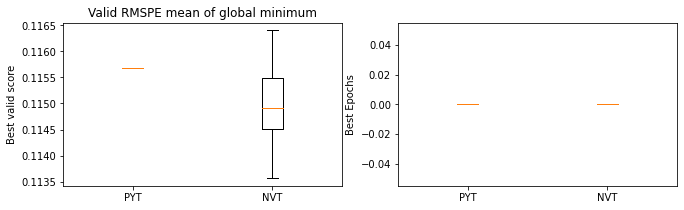

In [15]:
plot_basic(pd_pyt_mm, pd_nvt_mm, 'Valid RMSPE mean of global minimum')

# Analyse optimal NVT configuration

Let's compare the different NVTabular data loader configuration and see, if there are patterns

In [16]:
keys = ['part_size', 'dl_shuffle', 'dl_part_per_chunk']
part_size = ['10MB', '50MB', '100MB', '500MB', '1GB']
dl_shuffle = pd_nvt['dl_shuffle'].drop_duplicates().values.tolist()
dl_part_per_chunk = sorted(pd_nvt['dl_part_per_chunk'].drop_duplicates().values.tolist())
key_values = {
    'part_size': part_size, 
    'dl_shuffle': dl_shuffle, 
    'dl_part_per_chunk': dl_part_per_chunk
}

First, we look at the parameters, `part_size`, `shuffle` and `part_per_chunk` independently.<br><br>
We see that for the valid RMSPE, a larger `part_size` or more `part_per_chunk` have lower variance. But there is not a clear trend in median valid RMSPE. 

Text(0.5, 1.0, 'Valid RMSPE')

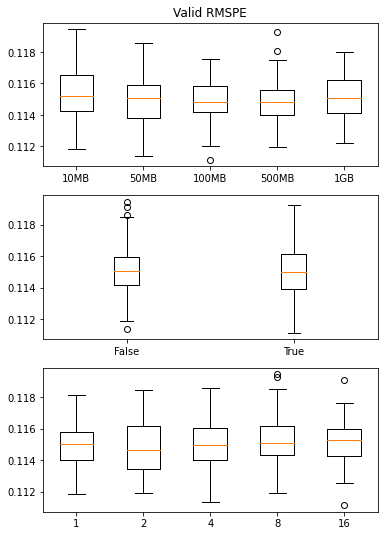

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(6,9))

for i in range(3):
    df_tmp = pd_nvt[col_keys + [metric]].groupby(col_keys).min().reset_index()[[keys[i], metric]]
    y_values = [df_tmp[df_tmp[keys[i]]==x][metric].values.tolist() for x in key_values[keys[i]]]
    ax[i].boxplot(y_values)
    ax[i].set_xticklabels(key_values[keys[i]])

ax[0].set_title('Valid RMSPE')

Text(0.5, 1.0, 'Best epoch')

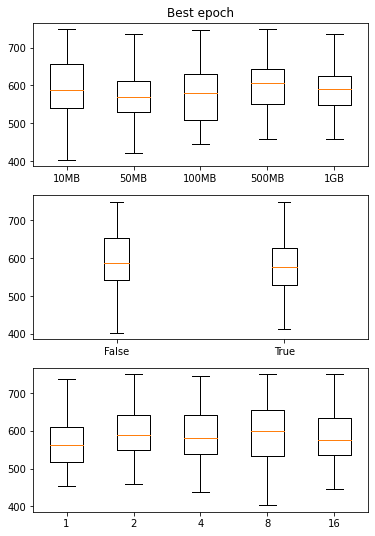

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(6,9))

for i in range(3):
    df_tmp = pd_nvt[col_keys + ['epoch', metric]].sort_values(metric).groupby(col_keys).head(1)[[keys[i], 'epoch']]
    y_values = [df_tmp[df_tmp[keys[i]]==x]['epoch'].values.tolist() for x in key_values[keys[i]]]
    ax[i].boxplot(y_values)
    ax[i].set_xticklabels(key_values[keys[i]])

ax[0].set_title('Best epoch')

In computation time, we see that `shuffle=False` is significant faster than with `True`.

Text(0.5, 1.0, 'Computation time')

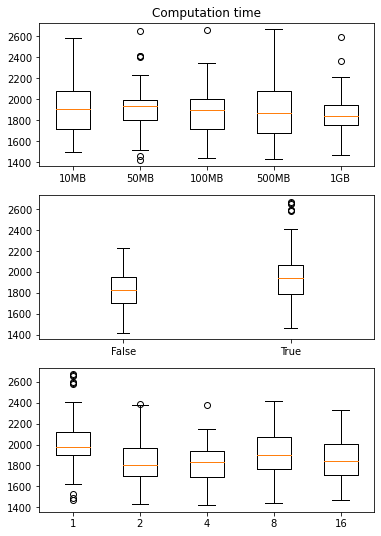

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(6,9))

for i in range(3):
    df_tmp = pd_nvt[col_keys + ['runtime']].drop_duplicates()
    y_values = [df_tmp[df_tmp[keys[i]]==x]['runtime'].values.tolist() for x in key_values[keys[i]]]
    ax[i].boxplot(y_values)
    ax[i].set_xticklabels(key_values[keys[i]])

ax[0].set_title('Computation time')

We can take a look on a heatmap for each configuration and see, if we find patterns.

/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='None-dl_part_per_chunk', ylabel='dl_shuffle-part_size'>

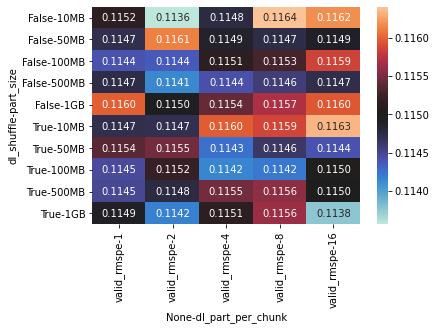

In [21]:
df_tmp = pd_nvt_mm[['part_size', 'dl_shuffle', 'dl_part_per_chunk', 'valid_rmspe']]
df_tmp['part_size'] = pd.Categorical(df_tmp['part_size'], categories=part_size, ordered=True) 
df_tmp_unstack = df_tmp.set_index(['dl_shuffle', 'part_size', 'dl_part_per_chunk']).unstack(level=-1)
sns.heatmap(df_tmp_unstack, annot=True, fmt='.4f', center=df_tmp_unstack.mean().mean())

We can compare how many configuration performs in average better than the native PyTorch data loader.

In [22]:
np.mean(np.mean(df_tmp_unstack<pd_pyt_mm[metric].values[0]))

0.8

In the end, the configuration does not effect significantly the performance in this use case - meaning, that there is not much hyperparameter tuning necessary, enabling the NVTabular data loader for PyTorch ready to use.